# TF 2.0 alpha - Text Classification

## Train a Neural Network to classify Movie Review text

### The IMDb dataset - 50,000 movie reviews - 25,000 train, 25,000 test
### BINARY Classification - reviews as Positive or Negative - sets are Balanced

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0-alpha0


## DOWNLOAD the DATASET

#### Preprocessed - reviews (sequence of words) were converted to sequences of integers
#### Preprocessed - labels, integer value 0 (negative) or 1 (positive)

In [3]:
# num_words keeps top 10000 frequent occuring words in the training data

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 6s 0us/step


## EXPLORE the DATA

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [6]:
# Reviews converted to integers - each integer represents a specific dictionary word

print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [7]:
# Reviews can be different lengths - check the first 2

len(train_data[0]), len(train_data[1])

(218, 189)

### Need to be the Same Length to be fed to the neural network - Address this

In [8]:
# How To Convert integers back to words 
# create helper function - query dict object containing integer to string mapping

# Dict mapping words to an integer index
word_index = imdb.get_word_index()

# the 1st indices are reversed
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 1s 1us/step


In [9]:
# Now convert the 1st review to text - with decode_review

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## PREPARE the DATA

#### Reviews (array of integers) must be converted to TENSORS to feed network

#### Can be done by - Converting arrays to Vectors of 0s and 1s for occurrence. [3,5] would be a 10000-dimension vector, all 0s except for indices 3 and 5 (1s). Make the 1st layer Dense, handling floating-point vector data. This method is very memory intensive - need num_words*num_reviews

#### Can also be done by - Pad arrays to all have the same length. Create integer Tensor of the following shape, max_length*num_reviews - use an Embedding layer to handle this

In [12]:
# Pad arrays with pad_sequences - to make reviews the Same length

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)
                                                    

In [13]:
# check the Length of the 1st two reviews

len(train_data[0]), len(train_data[1])

(256, 256)

In [14]:
# the 1st review is now padded

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## BUILD the MODEL

In [16]:
# input size - 10000, vocabulary count used for the movie reviews
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### LAYERS explained

#### EMBEDDING - finds embedding vector from integer-encoded vocab for each word-index. Vectors are learned as model trains - vectors add a dimension to output - resulting dimentions (batch, sequence, embedding)

#### GlobalAveragePooling1D - returns fixed-length vector output for each example by averaging over sequence dimension

#### DENSE - received fixed-length vector, into this dense layer with 16 Hidden Units

#### DENSE - last layer, output to a single node, through Sigmoid activation to a value between 0 - 1 (as probability or confidence level)

### LOSS FUNCTION and OPTIMIZER

In [18]:
# binary classification LF  -  binary_crossentropy 
# (better than mean_squared_error for probability)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

### Create a VALIDATION Set

In [19]:
# set apart 10000 examples from Training data - Tune model w Only Training
# use Test data for Evaluation 

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## TRAIN the MODEL

In [20]:
# 40 iterations over samples in the x_train and y_train Tensors
# mini-batches of 512 samples

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 75us/sample - loss: 0.6920 - accuracy: 0.5449 - val_loss: 0.6902 - val_accuracy: 0.6023
Epoch 2/40
15000/15000 [==============================] - 1s 51us/sample - loss: 0.6861 - accuracy: 0.6963 - val_loss: 0.6813 - val_accuracy: 0.7497
Epoch 3/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6724 - accuracy: 0.7567 - val_loss: 0.6645 - val_accuracy: 0.7624
Epoch 4/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.6491 - accuracy: 0.7667 - val_loss: 0.6379 - val_accuracy: 0.7665
Epoch 5/40
15000/15000 [==============================] - 1s 71us/sample - loss: 0.6150 - accuracy: 0.7964 - val_loss: 0.6025 - val_accuracy: 0.7914
Epoch 6/40
15000/15000 [==============================] - 1s 52us/sample - loss: 0.5724 - accuracy: 0.8171 - val_loss: 0.5617 - val_accuracy: 0.8068
Epoch 7/40
15000/15000 [==============================] 

## EVALUATE the MODEL

In [21]:
# see how model performs on Test data

results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 41us/sample - loss: 0.3299 - accuracy: 0.8717
[0.3298908181619644, 0.87172]


### Accuracy of about 87 %

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### History Object records training - the 4 monitored metrics during training and validation

## Create a GRAPH - Accuracy and Loss over Time

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo is 'blue dot' - b is 'solid blue line'

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

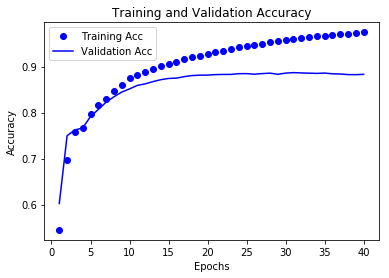

In [27]:
# clear figure 

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Validation Loss and Accracy appear to peak and plateau - example of Overfitting

### Model performs better on data it has seen, than on new data

### Address this by Stopping the Epochs around 20 

In [29]:

# this TF example was modeled after  -  "Text classification with movie reviews"
#@title MIT License
#
# Copyright (c) 2017 François Chollet